# Backpropagation for MLP Assignment

## Guidelines

* Do not use any more packages than the ones provided in the notebook.
* Do not make any changes outside the blocks that state "YOUR CODE HERE".
* To make sure that your assignment is submitted correctly, click the "Submit" button and check the grades.

## Backpropagation for a Neural Network

This assignment illustrates how backpropagation can be used to train a neural network by performing a simple binary classification problem using the MNIST dataset. You will be completing a portion of the backpropagation algorithm in this notebook. Note that your implementation of the backpropagation algorithm will have a few modifications since the gradients need to aggregated (by summing) the contributions from each training sample.

We begin by loading the necessary packages and generating the data. We set a binary classification in which the number 2 is considered as a positive instance, and all the other digits are considered as negative instances.

In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Import MNIST data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, parser="auto")

# Getting training and testing data:
# We are setting up just a simple binary classification problem in which we aim to
# properly classify the number 2.
X, y_str = mnist["data"], mnist["target"]
if not (type(X) is np.ndarray):
    X = X.to_numpy()
y = np.array([int(int(i) == 2) for i in y_str])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The next cell defines some helper functions.

In [3]:
# Function evaluating the sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Function evaluating the derivative of the sigmoid
def sigmoidPrime(x):
    return sigmoid(x) * (1 - sigmoid(x))


# Function evaluating the entropy loss
def net_loss(y, yhat):
    y = y.reshape([len(y), 1])
    return np.sum(-(1 - y) * np.log(1 - yhat) - y * np.log(yhat))


# Function to determine the number of mismatches on the prediction
def net_missed(y, yhat):
    y = y.reshape([len(y), 1])
    return np.sum(np.abs(y - (yhat > 0.5)))

The next portion of the code contains the main functions performing the initialization and prediction using the neural network.

In [4]:
# Setting a seed for random number generator
rng = np.random.default_rng(seed=42)


# Function used to initialize the parameters of the neural network. No fancy
# initialization here, just fixed Gaussians.
def net_init(net):
    for i in range(1, len(net["struct"])):
        net["W"][i] = 0.01 * rng.normal(size=[net["struct"][i], net["struct"][i - 1]])
        net["b"][i] = np.zeros([net["struct"][i], 1])


# Function used to create the neural network structure. The input is a list
# of parameters corresponding to the length of the input, hidden and output
# layers. The output is a dictionary that contains all the parameters of the
# neural network.
def net_create(st):
    net = {"struct": st, "W": {}, "b": {}, "a": {}, "h": {}}
    net_init(net)
    return net


# Function used to evaluate the neural network
def net_predict(net, X):
    o = np.ones([1, X.shape[0]])

    net["h"][0] = np.transpose(X)
    for k in range(0, len(net["W"])):
        net["a"][k + 1] = np.matmul(net["b"][k + 1], o) + np.matmul(
            net["W"][k + 1], net["h"][k]
        )
        net["h"][k + 1] = sigmoid(net["a"][k + 1])

    return np.transpose(net["h"][len(net["W"])])

Your task is to complete the backpropagation function. Make sure all the dimensions are consistent with what was done in class.

In [5]:
# Function using backpropagation to compute the gradients of the parameters
def net_backprop(net, X, y):
    # Performing forward propagation
    yhat = net_predict(net, X)

    # Initializing gradients
    B_b = [None] * (len(net["struct"]))
    B_W = [None] * (len(net["struct"]))

    # Implementation of gradients based on backpropagation algorithm
    G = yhat - y.reshape([len(y), 1])
    for k in range(len(net["W"]), 0, -1):
        ###
        ### YOUR CODE HERE
        ###
        if k == len(net["W"]):
            dX = G @ net["W"][k]
            dB = np.sum(G, axis=0, keepdims=True).T
            dW = net["h"][k - 1] @ G
        else:
            Z = net["a"][k]
            dZ = sigmoidPrime(Z).T * dX
            dB = np.sum(dZ, axis=0, keepdims=True)
            dW = net["h"][k - 1] @ dZ
        B_b[k] = dB
        B_W[k] = dW

    return B_b, B_W

The next portion of the code contains the function for training the neural network.

In [6]:
# Function used for training of the neural network. It updates the parameters
# in the neural network and returns the history of the training Loss 'Loss',
# the validation loss 'Loss_val' and the number of missed prediction in the
# validation set 'missed_val'.
def net_train(net, X_train, y_train, X_val, y_val, epsilon, NIter):
    # Initializing arrays holding the history of loss and missed values
    Loss = np.zeros(NIter)
    Loss_val = np.zeros(NIter)
    missed_val = np.zeros(NIter)

    # Simple implementation of gradient descent
    for n in range(0, NIter):
        # Computing gradient and updating parameters
        DC_b, DC_W = net_backprop(net, X_train, y_train)
        for k in range(0, len(net["W"])):
            net["b"][k + 1] = net["b"][k + 1] - epsilon * np.transpose(DC_b[k + 1])
            net["W"][k + 1] = net["W"][k + 1] - epsilon * np.transpose(DC_W[k + 1])

        # Computing losses and missed values for the validation set
        Loss[n] = net_loss(y_train, np.transpose(net["h"][len(net["W"])]))
        yhat_val = net_predict(net, X_val)
        Loss_val[n] = net_loss(y_val, yhat_val)
        missed_val[n] = net_missed(y_val, yhat_val)

        # Displaying results for the current epoch
        print(
            "... Epoch {:3d} | Loss_Train: {:.2E} | Loss_Val: {:.2E} | Acc_Val: {:2.2f}".format(
                n, Loss[n], Loss_val[n], 100 - 100 * (missed_val[n]) / len(yhat_val)
            )
        )

    return Loss, Loss_val, missed_val

Next we make sure that the dimensions and values of the gradient are correct for a two layer network.

In [7]:
# Creating a neural network structure
net = net_create([784, 100, 1])

# Computing gradients
B_b, B_W = net_backprop(net, X_train, y_train)

Running tests for gradient dimensions [2pt]

In [8]:
assert len(B_b) == len(net["struct"]), " number of gradient vectors is not correct"
assert len(B_W) == len(net["struct"]), " number of gradient vectors is not correct"

assert B_b[0] == None, "the gradients for an index of 0 are not empty"
assert B_W[0] == None, "the gradients for an index of 0 are not empty"

# assert len(B_b[2])==1,'the dimensions of the individual gradients are not correct'
assert (
    B_b[1].shape[0] == 1
), "the dimensions of the individual gradients are not correct"
assert (
    B_b[1].shape[1] == 100
), "the dimensions of the individual gradients are not correct"
assert (
    B_W[1].shape[0] == 784
), "the dimensions of the individual gradients are not correct"
assert (
    B_W[1].shape[1] == 100
), "the dimensions of the individual gradients are not correct"
assert (
    B_W[2].shape[0] == 100
), "the dimensions of the individual gradients are not correct"
assert (
    B_W[2].shape[1] == 1
), "the dimensions of the individual gradients are not correct"

Running first test for gradient norm [2pt]

In [9]:
assert np.abs(B_b[2] - 24631.04) < 0.1, "gradient norm is not correct"
assert np.abs(B_W[2][50] - 9015.61) < 0.1, "gradient norm is not correct"

Running second test for gradient norm [2pt]

In [10]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###

Finally, the two networks are fully trained to compare their performance. Note that since we are not doing any hyper-parameter tuning, we use the test sets for validation to show how the generalization error changes as the network gets trained. If we use this test set as stopping criteria for training then we would need to find a different set for our final evaluation.

... Epoch   0 | Loss_Train: 4.09E+04 | Loss_Val: 4.23E+03 | Acc_Val: 89.68
... Epoch   1 | Loss_Train: 2.52E+04 | Loss_Val: 3.47E+03 | Acc_Val: 89.68
... Epoch   2 | Loss_Train: 2.06E+04 | Loss_Val: 3.22E+03 | Acc_Val: 89.68
... Epoch   3 | Loss_Train: 1.90E+04 | Loss_Val: 3.08E+03 | Acc_Val: 89.68
... Epoch   4 | Loss_Train: 1.82E+04 | Loss_Val: 2.97E+03 | Acc_Val: 89.68
... Epoch   5 | Loss_Train: 1.75E+04 | Loss_Val: 2.86E+03 | Acc_Val: 89.68
... Epoch   6 | Loss_Train: 1.68E+04 | Loss_Val: 2.75E+03 | Acc_Val: 89.68
... Epoch   7 | Loss_Train: 1.62E+04 | Loss_Val: 2.65E+03 | Acc_Val: 89.68
... Epoch   8 | Loss_Train: 1.57E+04 | Loss_Val: 2.56E+03 | Acc_Val: 89.68
... Epoch   9 | Loss_Train: 1.51E+04 | Loss_Val: 2.47E+03 | Acc_Val: 89.68
... Epoch  10 | Loss_Train: 1.46E+04 | Loss_Val: 2.39E+03 | Acc_Val: 89.68
... Epoch  11 | Loss_Train: 1.42E+04 | Loss_Val: 2.31E+03 | Acc_Val: 89.68
... Epoch  12 | Loss_Train: 1.37E+04 | Loss_Val: 2.24E+03 | Acc_Val: 89.68
... Epoch  13 | Loss_Trai

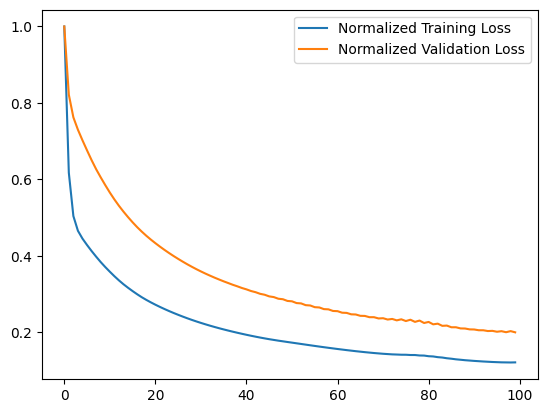

In [11]:
# Creating the network structure
net = net_create([784, 100, 1])

# Training the first network
Loss, Loss_val, missed_val = net_train(
    net, X_train, y_train, X_test, y_test, epsilon=1e-6, NIter=100
)

# Plotting learning curves:
plt.plot(Loss / np.max(Loss))
plt.plot(Loss_val / np.max(Loss_val))
plt.legend({"Normalized Training Loss", "Normalized Validation Loss"})
plt.show()

Running test for final accuracy. Note that if you happen to have a bad initialization, then you may fail this test. Try submitting the assignment a couple of times to check that this is not the case. [2pt]

Also, note that the grading of this script will take a little longer than usual since it needs to train the entire neural network in the backend. We are using CPUs so the training is a little slow.

In [12]:
assert (
    100 - 100 * (missed_val[-1]) / len(y_test)
) > 97, " the final value of accuracy is not correct"